# CatBoost (CatBoostClassifier) 분석 (독립 실행용)

데이터 로딩부터 성능평가·과적합 확인·SHAP·결과 저장까지 수행합니다.

## 라이브러리

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
try:
    from IPython.display import display
except ImportError:
    display = print
from matplotlib import pyplot as plt
plt.ioff()
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    log_loss,
)
import shap
import os

my_dpi = 100

In [2]:
import sys
sys.path.insert(0, r'C:\\itwill_bigdata_final_project-main\\itwill_bigdata_final_project\\3. 결측 변수 제거 없이 분석 진행')

# 2. 로지스틱+성능평가+shap copy에서 정의한 함수를 공통 모듈에서 import (다른 ipynb에서도 동일하게 사용 가능)
from analysis_utils import (
    hs_get_scores, hs_describe, category_describe, hs_feature_importance,
    create_figure, finalize_plot, hs_learning_cv, hs_get_score_cv,
    my_shap_analysis, hs_shap_dependence_analysis, my_dpi,
)

## 데이터 로딩 (2. 로지스틱+성능평가+shap copy와 동일)

In [3]:
from pandas import read_csv

origin = read_csv(
    r'C:\itwill_bigdata_final_project-main\itwill_bigdata_final_project\1. 초기 데이터 전처리\3.coding_book_mapping.csv',
    encoding='utf-8'
)
origin.head()

,w09_fam1,w09_fam2,w09hhsize,w09edu,w09gender1,w09a002_age,w09marital,w09year2,w09edu_s,w09ecoact_s,w09enu_type,w09ba003,w09livewithnm,w09ba069,w09bp1,w09c152,w09c001,w09c003,w09c005,w09chronic_a,w09chronic_b,w09chronic_c,w09chronic_d,w09chronic_e,w09chronic_f,w09chronic_g,w09chronic_h,w09chronic_i,w09chronic_j,w09chronic_k,w09chronic_l,w09chronic_m,w09c056,w09c068,w09c081,w09c082,w09c085,w09c102,w09bmi,w09c108,w09c111,w09smoke,w09alc,w09addic,w09c318,w09c330,w09c333,w09c334,w09c337,w09c340,w09adl,w09c550,w09mgrip,w09fromchildren,w09tochildren,w09transferfrom,w09transferto,w09earned,w09pinc,w09e201,w09e207,w09e213,w09e219,w09e225,w09e231,w09e237,w09e243,w09e273,w09e251,w09passets,w09pliabilities,w09pnetassets,w09f001type,w09hhinc,w09hhassets,w09hhliabilities,w09hhnetassets,w09g032,w09g026,w09g027,w09g028,w09g029,w09g030,w09g031,w09cadd_19,w09c142,w09c143,w09c144,w09c145,w09c146,w09c147,w09c148,w09c149,w09c150,w09c151,dependent_ecotype,dependent_wage_work,work_ability_age
0,1세대,부부,2,대졸이상,여,67.000,혼인중,1954.000,대졸이상,취업,1,2,NaN,아니오,두분 모두 사망 혹은 안 계심 (실종),보통,좋은 편,아니오,그렇지 않은 편이다,아니오,예,아니오,아니오,아니오,아니오,아니오,아니오,예,NaN,아니오,아니오,NaN,아니오,NaN,아니오,아니오,아니오,아니오,24.030,1,5.000,비흡연자,비음주자,NaN,0.000,0.000,0.000,0.000,2.000,0.000,0,예,21.500,15.000,NaN,15.000,NaN,NaN,375.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35500.000,NaN,35500.000,전세,13000.000,30000.000,10000.000,20000.000,20.000,70.000,60.000,70.000,70.000,80.000,중의 상,아니오,하루 미만,하루 미만,하루 미만,하루 미만,3-4일,하루 미만,하루 미만,하루 미만,5-7일,하루 미만,0,0,NaN
1,1세대,부부,2,대졸이상,남,68.000,혼인중,1955.000,대졸이상,비경활,1,2,NaN,아니오,두분 모두 사망 혹은 안 계심 (실종),보통,좋은 편,아니오,그런 편이다,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,예,아니오,아니오,NaN,아니오,NaN,아니오,아니오,아니오,아니오,21.470,1,5.000,과거흡연자,현재음주자,정상,0.000,0.000,0.000,0.000,4.000,0.000,0,아니오,NaN,15.000,NaN,15.000,NaN,2400.000,2415.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,전세,13000.000,30000.000,10000.000,20000.000,20.000,70.000,70.000,70.000,NaN,60.000,중의 상,아니오,하루 미만,하루 미만,하루 미만,하루 미만,5-7일,하루 미만,하루 미만,3-4일,하루 미만,하루 미만,1,1,30.000
2,1세대,부부,2,초졸이하,남,80.000,혼인중,1946.000,초졸이하,비경활,1,2,NaN,아니오,두분 모두 사망 혹은 안 계심 (실종),좋은 편,매우 좋음,아니오,그렇지 않은 편이다,예,예,아니오,아니오,아니오,아니오,아니오,아니오,예,아니오,아니오,아니오,NaN,아니오,NaN,아니오,아니오,아니오,아니오,21.970,1,7.000,과거흡연자,과거음주자,NaN,0.000,0.000,0.000,0.000,6.000,0.000,0,예,31.500,175.000,50.000,175.000,50.000,NaN,10663.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30000.000,10000.000,20000.000,자기집,11200.000,33000.000,10000.000,23000.000,10.000,70.000,60.000,40.000,NaN,60.000,중의 하,아니오,하루 미만,하루 이틀,하루 이틀,하루 이틀,3-4일,하루 이틀,하루 미만,3-4일,하루 이틀,하루 미만,0,0,NaN
3,1세대,부부,2,초졸이하,여,76.000,혼인중,1942.000,초졸이하,비경활,1,2,NaN,아니오,두분 모두 사망 혹은 안 계심 (실종),보통,좋은 편,아니오,그렇지 않은 편이다,예,예,아니오,아니오,아니오,아니오,아니오,아니오,예,NaN,아니오,아니오,NaN,아니오,아니오,아니오,아니오,예,예,21.480,1,5.000,비흡연자,과거음주자,NaN,0.000,0.000,0.000,0.000,6.000,0.000,0,예,19.250,175.000,50.000,175.000,50.000,NaN,823.000,100.000,50.000,5.000,0.000,0.000,13.000,15.000,5.000,0.000,0.000,10200.000,10000.000,200.000,자기집,11200.000,33000.000,10000.000,23000.000,20.000,70.000,60.000,30.000,80.000,60.000,중의 하,아니오,하루 미만,하루 이틀,하루 미만,하루 이틀,3-4일,하루 미만,하루 미만,3-4일,하루 이틀,하루 미만,0,0,NaN
4,1세대,단독가구,1,초졸이하,여,78.000,사별 또는 실종 (이산가족),NaN,NaN,NaN,1,3,NaN,아니오,두분 모두 사망 혹은 안 계심 (실종),보통,좋은 편,아니오,전혀 그렇지 않다,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,아니오,NaN,아니오,아니오,NaN,아니오,NaN,아니오,아니오,예,예,22.010,1,5.000,비흡연자,비음주자,NaN,0.000,0.000,0.000,0.000,6.000,0.000,0,예,17.000,170.000,NaN,170.000,NaN,NaN,710.000,100.000,40.000,5.000,0.000,0.000,10.000,5.000,5.000,5.000,20.000,15000.000,10000.000,5000.000,자기집,11300.000,16000.000,10000.000,6000.000,10.000,60.000,60.000,NaN,70.000,70.000,하의 상,아니오,하루 미만,하루 이틀,하루 이틀,하루 미만,3-4일,하루 이틀,3-4일,3-4일,하루 이틀,하루 이틀,0,0,NaN


In [4]:
categorical_cols = [
    'w09_fam1','w09_fam2','w09edu','w09gender1','w09marital','w09edu_s','w09ecoact_s','w09enu_type',
    'w09ba069','w09bp1','w09c152','w09c001','w09c003','w09c005',
    'w09chronic_a','w09chronic_b','w09chronic_c','w09chronic_d','w09chronic_e','w09chronic_f',
    'w09chronic_g','w09chronic_h','w09chronic_i','w09chronic_j','w09chronic_k','w09chronic_l','w09chronic_m',
    'w09c056','w09c068','w09c081','w09c082','w09c085','w09c102',
    'w09smoke','w09alc','w09addic','w09c550',
    'w09f001type','w09g031',
    'w09cadd_19','w09c142','w09c143','w09c144','w09c145','w09c146','w09c147','w09c148','w09c149','w09c150','w09c151'
]

In [5]:
origin_type_changed = origin.copy()
cat_cols_for_type = [c for c in categorical_cols if c in origin_type_changed.columns]
origin_type_changed[cat_cols_for_type] = origin_type_changed[cat_cols_for_type].astype("category")
origin = origin_type_changed.copy()

In [6]:
origin2 = origin.drop(['dependent_wage_work'], axis=1)
yname = "dependent_ecotype"
# 결측치가 50% 초과인 변수 제거 (타깃 제외)
missing_rate = origin2.isnull().mean()
drop_high_missing = [c for c in missing_rate[missing_rate > 0.5].index if c != yname]
origin3 = origin2.drop(columns=drop_high_missing)
print(f'결측 50% 초과 변수 제거: {len(drop_high_missing)}개 제거, 남은 컬럼 {origin3.shape[1]}개')
df2 = origin3.copy()
df3 = df2.copy()

drop_for_leakage = [yname, 'work_ability_age']
x = df3.drop(columns=[c for c in drop_for_leakage if c in df3.columns])
y = df3[yname].astype(int)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52, stratify=y
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


결측 50% 초과 변수 제거: 11개 제거, 남은 컬럼 86개


((4542, 85), (1515, 85), (4542,), (1515,))

## #01 컬럼 타입 분리

**전처리 기준:** `2. 로지스틱 + 성능평가 + shap copy.ipynb` 파이프라인과 동일
- **연속형** (int64, float64): 결측 → median 대체 후 StandardScaler
- **명목형** (object, category): 결측 → 'Missing' 대체 후 OneHotEncoder(drop='first', handle_unknown='ignore')
- 컬럼 구분: train 기준 `select_dtypes`로 자동 분리

In [7]:
# 2. 로지스틱+성능평가+shap copy와 동일한 컬럼 타입 분리 기준
cat_cols = x_train.select_dtypes(include=["object", "category"]).columns
num_cols = x_train.select_dtypes(include=["int64", "float64"]).columns
print("categorical:", len(cat_cols))
print("numeric:", len(num_cols))

categorical: 46
numeric: 39


## #02 전처리 + CatBoost 파이프라인 & GridSearchCV

In [8]:
# 2. 로지스틱+성능평가+shap copy와 동일한 ColumnTransformer (연속형/명목형 개별 파이프라인)
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", CatBoostClassifier(random_state=52, verbose=0))
])

param_grid = {
    "model__iterations": [100, 200],
    "model__depth": [3, 5, 7],
    "model__learning_rate": [0.05, 0.1],
    "model__l2_leaf_reg": [1, 3],
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

gs.fit(x_train, y_train)
estimator = gs.best_estimator_

print("Best CV AUC:", gs.best_score_)
print("Best params:", gs.best_params_)

Best CV AUC: 0.9020803675357474
Best params: {'model__depth': 7, 'model__iterations': 200, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.05}


## #03 예측값

In [9]:
y_pred = estimator.predict(x_test)
y_pred_proba = estimator.predict_proba(x_test)
y_pred_proba_1 = y_pred_proba[:, 1]
y_pred[:5], y_pred_proba_1[:5]

c:\Users\itwill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0, 18, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\itwill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0, 18, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(array([0, 1, 0, 1, 0], dtype=int64),
 array([0.12687986, 0.51900079, 0.36297711, 0.73520808, 0.04889671]))

## #04 성능 평가

In [10]:
cm = confusion_matrix(y_test, y_pred)
((TN, FP), (FN, TP)) = cm
print(TN, FP, FN, TP)

cmdf = DataFrame(
    cm,
    index=['Actual 0 (TN/FP)', 'Actual 1 (FN/TP)'],
    columns=['Predicted (Negative)', 'Predicted (Positive)']
)
display(cmdf)

926 78 150 361


,Predicted (Negative),Predicted (Positive)
Actual 0 (TN/FP),926,78
Actual 1 (FN/TP),150,361


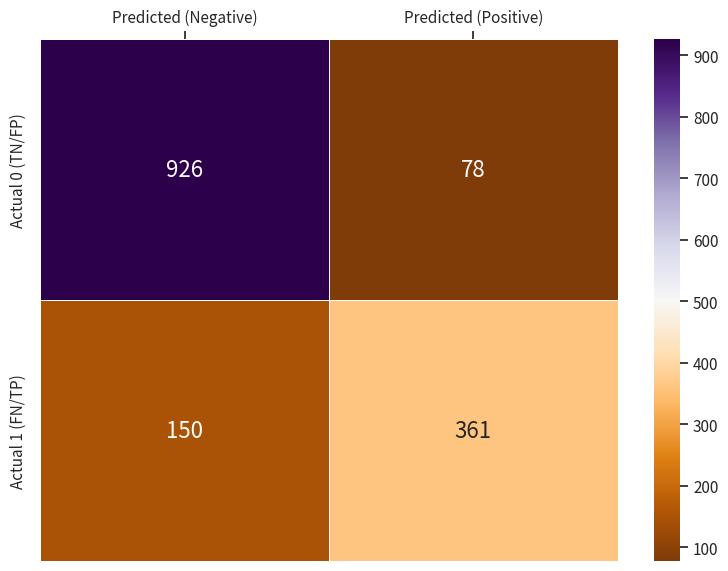

In [11]:
width_px, height_px = 800, 600
fig, ax = plt.subplots(1, 1, figsize=(width_px / my_dpi, height_px / my_dpi), dpi=my_dpi)
sb.heatmap(data=cmdf, annot=True, fmt="d", linewidth=0.5, cmap="PuOr")
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()
plt.tight_layout()
plt.show()
plt.close()

In [12]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
tpr = recall_score(y_test, y_pred)
fpr = FP / (TN + FP)
tnr = 1 - fpr
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba_1)

y_null = np.ones_like(y_test) * y_test.mean()
log_loss_test = -log_loss(y_test, y_pred_proba, normalize=False)
log_loss_null = -log_loss(y_test, y_null, normalize=False)
pseudo_r2 = 1 - (log_loss_test / log_loss_null)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall(TPR):", tpr)
print("FPR:", fpr)
print("TNR:", tnr)
print("F1:", f1)
print("AUC:", auc)
print("Pseudo R2:", pseudo_r2)

Accuracy: 0.8495049504950495
Precision: 0.8223234624145785
Recall(TPR): 0.7064579256360078
FPR: 0.07768924302788845
TNR: 0.9223107569721115
F1: 0.76
AUC: 0.9142432228035021
Pseudo R2: 0.4586198796263792


### ROC 곡선

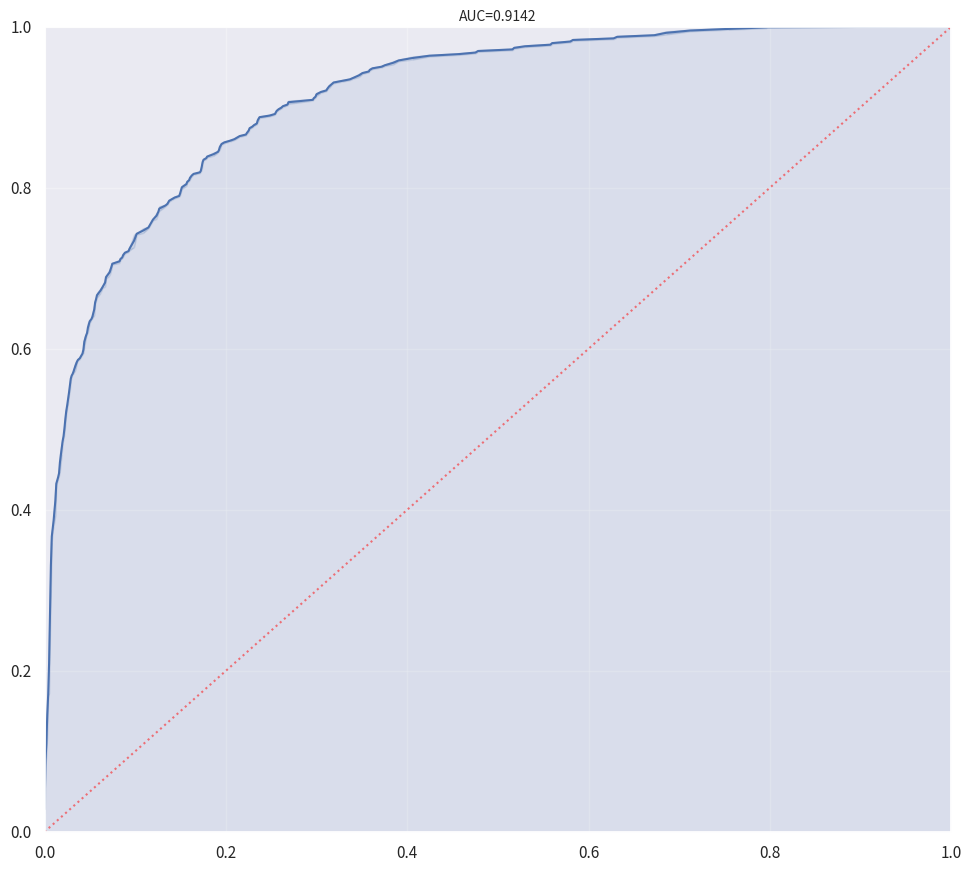

In [13]:
roc_fpr, roc_tpr, _ = roc_curve(y_test, y_pred_proba_1)
fig, ax = plt.subplots(1, 1, figsize=(1000 / my_dpi, 900 / my_dpi), dpi=my_dpi)
sb.lineplot(x=roc_fpr, y=roc_tpr)
sb.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle=":", alpha=0.5)
plt.fill_between(x=roc_fpr, y1=roc_tpr, alpha=0.1)
ax.grid(True, alpha=0.3)
ax.set_title(f"AUC={auc:.4f}", fontsize=10, pad=4)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()
plt.close()

### 결과표

In [14]:
if hasattr(estimator, "named_steps"):
    classname = estimator.named_steps["model"].__class__.__name__
else:
    classname = estimator.__class__.__name__

score_df = DataFrame(
    {
        "의사결정계수(R2)": [round(pseudo_r2, 3)],
        "정확도(Accuracy)": [round(accuracy, 3)],
        "정밀도(Precision)": [round(precision, 3)],
        "재현율(Recall)": [round(tpr, 3)],
        "위양성율(Fallout)": [round(fpr, 3)],
        "특이성(TNR)": [round(tnr, 3)],
        "F1 Score": [round(f1, 3)],
        "AUC": [round(auc, 3)],
    },
    index=[classname]
)
score_df

,의사결정계수(R2),정확도(Accuracy),정밀도(Precision),재현율(Recall),위양성율(Fallout),특이성(TNR),F1 Score,AUC
CatBoostClassifier,0.459,0.850,0.822,0.706,0.078,0.922,0.760,0.914


## #05 Learning Curve & 과적합 판정

In [15]:
train_sizes = np.linspace(0.1, 1.0, 10)
sizes, train_scores, cv_scores = learning_curve(
    estimator=estimator,
    X=x_train,
    y=y_train.astype(int),
    train_sizes=train_sizes,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    shuffle=True,
    random_state=52
)

train_mean = train_scores.mean(axis=1)
cv_mean = cv_scores.mean(axis=1)
cv_std = cv_scores.std(axis=1)
final_train = train_mean[-1]
final_cv = cv_mean[-1]
final_std = cv_std[-1]
gap_ratio = final_train - final_cv

print("Final Train AUC:", final_train)
print("Final CV AUC:", final_cv)
print("Final CV STD:", final_std)
print("Gap(Train-CV):", gap_ratio)

Final Train AUC: 0.9880657671706556
Final CV AUC: 0.9023176207331151
Final CV STD: 0.011837008595911011
Gap(Train-CV): 0.08574814643754058


In [16]:
if final_train < 0.6 and final_cv < 0.6:
    status = "⚠ 과소적합"
elif gap_ratio > 0.1:
    status = "⚠ 과대적합"
elif gap_ratio <= 0.05 and final_std <= 0.05:
    status = "✅ 일반화 양호"
elif final_std > 0.1:
    status = "⚠ 데이터 부족"
else:
    status = "⚠ 판단 보류"

result_df = DataFrame(
    {
        "Train ROC_AUC 평균": [round(final_train, 3)],
        "CV ROC_AUC 평균": [round(final_cv, 3)],
        "CV ROC_AUC 표준편차": [round(final_std, 3)],
        "Train/CV 비율": [round(gap_ratio, 3)],
        "CV 변동성 비율": [round(final_std, 3)],
        "판정 결과": [status],
    },
    index=[classname],
)
result_df

,Train ROC_AUC 평균,CV ROC_AUC 평균,CV ROC_AUC 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
CatBoostClassifier,0.988,0.902,0.012,0.086,0.012,⚠ 판단 보류


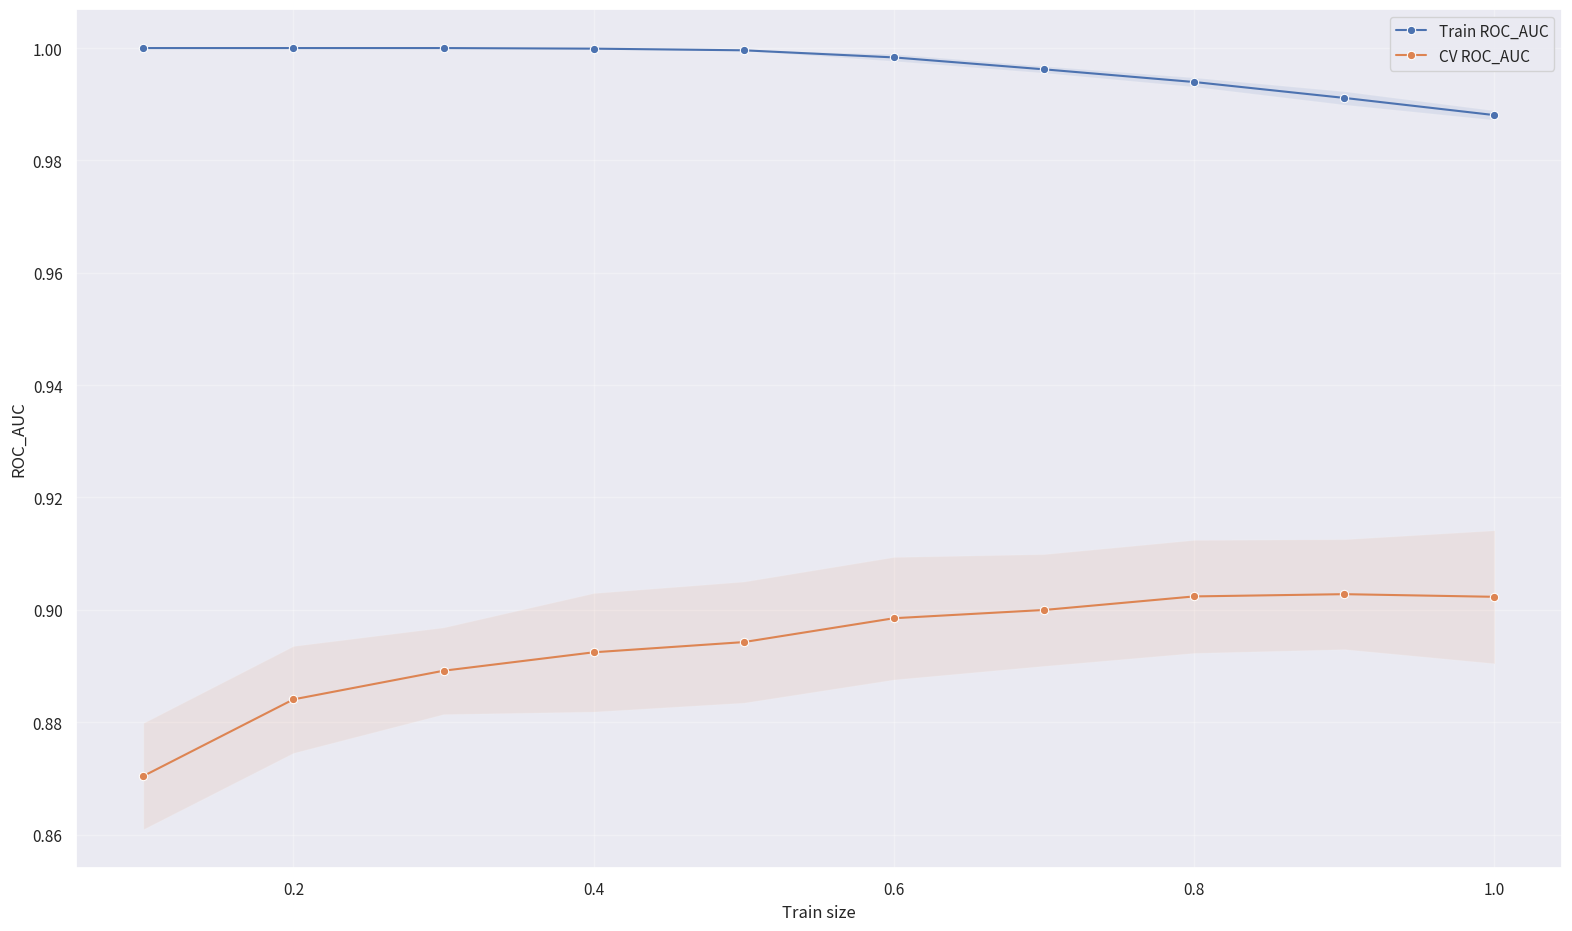

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(1600 / my_dpi, 960 / my_dpi), dpi=my_dpi)
sb.lineplot(x=train_sizes, y=train_mean, marker="o", markeredgecolor="#ffffff", label="Train ROC_AUC")
sb.lineplot(x=train_sizes, y=cv_mean, marker="o", markeredgecolor="#ffffff", label="CV ROC_AUC")
ax.fill_between(train_sizes, train_mean - train_scores.std(axis=1), train_mean + train_scores.std(axis=1), alpha=0.1)
ax.fill_between(train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.1)
ax.set_xlabel("Train size")
ax.set_ylabel("ROC_AUC")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

## #06 SHAP (CatBoost TreeExplainer)

전처리된 데이터와 내부 모델(CatBoostClassifier)로 TreeExplainer 적용.

In [18]:
X_train_transformed = estimator.named_steps["preprocess"].transform(x_train)
feature_names = estimator.named_steps["preprocess"].get_feature_names_out()
inner_model = estimator.named_steps["model"]
X_train_df = DataFrame(X_train_transformed, columns=feature_names, index=x_train.index)

explainer = shap.TreeExplainer(inner_model, data=X_train_df)
shap_values = explainer.shap_values(X_train_df)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap_df = DataFrame(shap_values, columns=feature_names, index=x_train.index)
summary_df = DataFrame(
    {
        "feature": shap_df.columns,
        "mean_abs_shap": shap_df.abs().mean().values,
        "mean_shap": shap_df.mean().values,
        "std_shap": shap_df.std().values,
    }
)
summary_df["direction"] = np.where(
    summary_df["mean_shap"] > 0, "양(+) 경향",
    np.where(summary_df["mean_shap"] < 0, "음(-) 경향", "혼합/미약")
)
summary_df = summary_df.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
total_importance = summary_df["mean_abs_shap"].sum()
summary_df["importance_ratio"] = summary_df["mean_abs_shap"] / total_importance
summary_df["importance_cumsum"] = summary_df["importance_ratio"].cumsum()
summary_df["is_important"] = np.where(summary_df["importance_cumsum"] <= 0.80, "core", "secondary")
display(summary_df.head(20))

 98%|===================| 4470/4542 [00:39<00:00]        

,feature,mean_abs_shap,mean_shap,std_shap,direction,importance_ratio,importance_cumsum,is_important
0,num__w09pinc,0.962,-0.078,1.049,음(-) 경향,0.196,0.196,core
1,num__w09a002_age,0.510,0.020,0.640,양(+) 경향,0.104,0.300,core
2,cat__w09ecoact_s_취업,0.382,-0.020,0.438,음(-) 경향,0.078,0.377,core
3,num__w09c108,0.228,0.043,0.238,양(+) 경향,0.047,0.424,core
4,cat__w09enu_type_2,0.174,0.012,0.179,양(+) 경향,0.036,0.460,core
5,cat__w09c005_그렇지 않은 편이다,0.161,-0.019,0.172,음(-) 경향,0.033,0.492,core
6,cat__w09ecoact_s_비경활,0.142,-0.015,0.155,음(-) 경향,0.029,0.521,core
7,num__w09fromchildren,0.137,-0.014,0.197,음(-) 경향,0.028,0.549,core
8,num__w09mgrip,0.125,0.005,0.151,양(+) 경향,0.025,0.575,core
9,num__w09hhinc,0.111,0.018,0.138,양(+) 경향,0.023,0.597,core


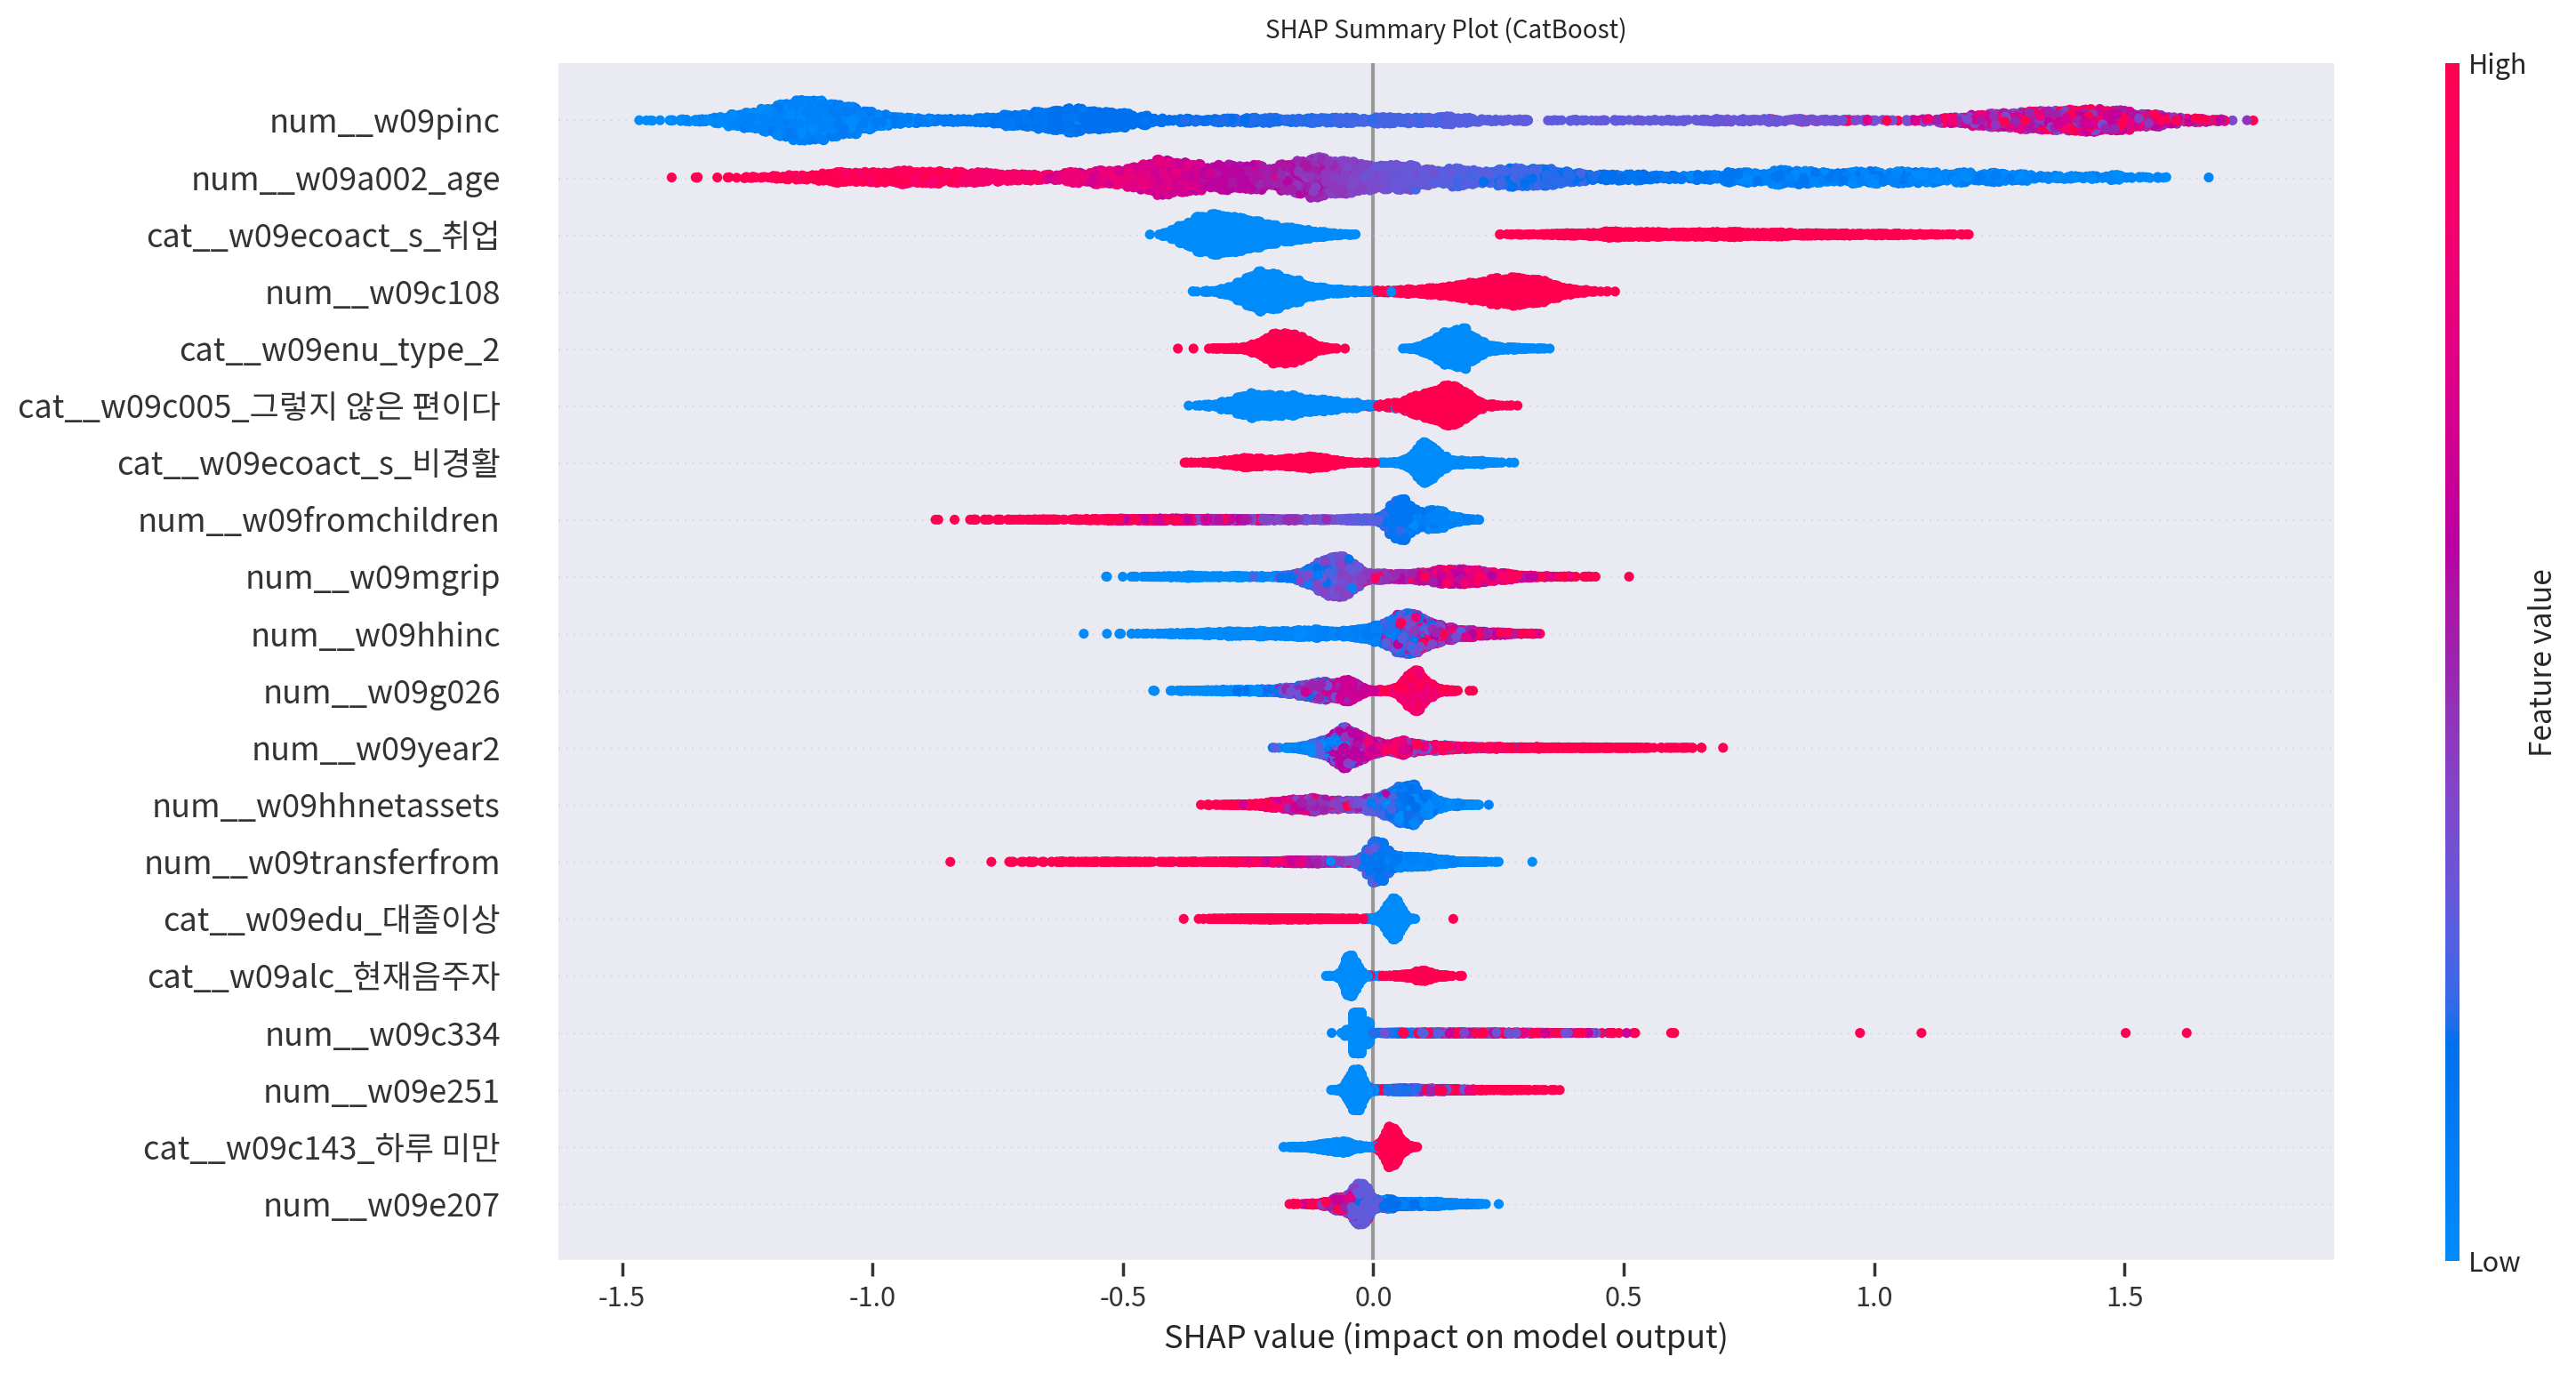

In [19]:
shap.summary_plot(shap_values, X_train_df, show=False)
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title("SHAP Summary Plot (CatBoost)", fontsize=10, pad=10)
plt.tight_layout()
plt.show()
plt.close()

## 결과 저장 (종합.ipynb에서 사용)

In [20]:
import pickle
os.makedirs('results', exist_ok=True)
save_name = 'new_CatBoost'
with open(os.path.join('results', save_name + '.pkl'), 'wb') as f:
    pickle.dump({
        'model_name': classname,
        'score_df': score_df,
        'result_df': result_df,
        'overfit_status': status,
        'estimator': estimator,
        'x_train': x_train,
        'x_test': x_test,
        'y_train': y_train,
        'y_test': y_test,
        'auc': auc,
    }, f)
print('Saved results to results/' + save_name + '.pkl')

Saved results to results/new_CatBoost.pkl
